In [1]:
#First attempt at implementing a basic GTN... 

In [2]:
import numpy as np
import pandas as pd
import higher
import matplotlib.pyplot as plt
import tqdm


plt.style.use('ggplot')

In [3]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

iris = load_iris()
X = iris['data']
y = iris['target']
names = iris['target_names']
feature_names = iris['feature_names']

#Scale data to have mean 0 and variance 1
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

#Split the data set into training and testing 

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled,y,test_size=0.2,random_state=2)


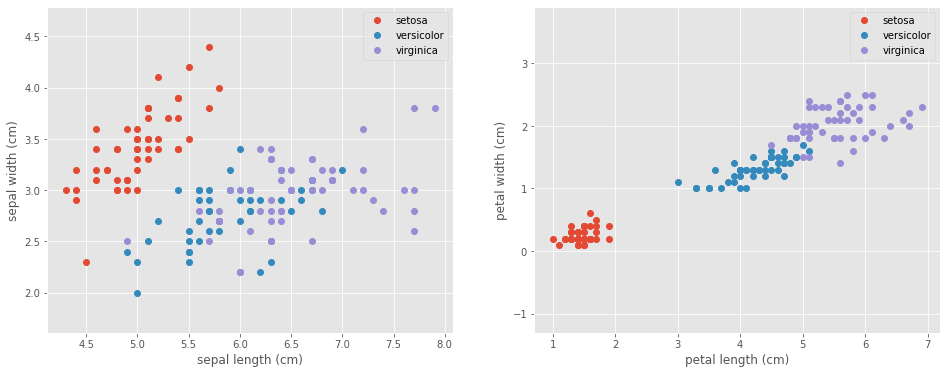

In [5]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
for target, target_name in enumerate(names):
    X_plot = X[y == target]
    ax1.plot(X_plot[:, 0], X_plot[:, 1], 
             linestyle='none', 
             marker='o', 
             label=target_name)
ax1.set_xlabel(feature_names[0])
ax1.set_ylabel(feature_names[1])
ax1.axis('equal')
ax1.legend();

for target, target_name in enumerate(names):
    X_plot = X[y == target]
    ax2.plot(X_plot[:, 2], X_plot[:, 3], 
             linestyle='none', 
             marker='o', 
             label=target_name)
ax2.set_xlabel(feature_names[2])
ax2.set_ylabel(feature_names[3])
ax2.axis('equal')
ax2.legend();

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F

X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).long()

X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test).long()

In [7]:
class Model(nn.Module):
    def __init__(self,input_dim):
        
        super().__init__()
        self.layer1 = nn.Linear(input_dim,50)
        self.layer2 = nn.Linear(50,50)
        self.layer3 = nn.Linear(50,3)
                
    def forward(self,x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        x = F.softmax(self.layer3(x),dim=1)
        return x


In [8]:
#Train above model on iris dataset
model = Model(X_train.shape[1])
optimizer = torch.optim.Adam(model.parameters(),lr=0.01)
criterion = nn.CrossEntropyLoss()
EPOCHS = 100
loss_list = np.zeros((EPOCHS,))
accuracy_list = np.zeros((EPOCHS,))

for epoch in tqdm.trange(EPOCHS):
    y_pred = model(X_train)
    loss = criterion(y_pred,y_train)
    loss_list[epoch] = loss.item()
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    

    #Record accuracy on training (or test?) set
    with torch.no_grad():
        y_pred = model(X_train)
        correct = (torch.argmax(y_pred,dim=1) == y_train).type(torch.FloatTensor)
        accuracy_list[epoch] = correct.mean()
        
        
    
print(accuracy_list)

100%|████████████████████████████████████████| 100/100 [00:00<00:00, 391.04it/s]

[0.75833333 0.73333335 0.73333335 0.71666664 0.72500002 0.72500002
 0.77499998 0.80833334 0.81666666 0.84166664 0.89999998 0.91666669
 0.92500001 0.93333334 0.95833331 0.94999999 0.93333334 0.94999999
 0.95833331 0.96666664 0.96666664 0.95833331 0.96666664 0.96666664
 0.97500002 0.97500002 0.97500002 0.96666664 0.96666664 0.97500002
 0.97500002 0.97500002 0.97500002 0.97500002 0.97500002 0.97500002
 0.98333335 0.98333335 0.97500002 0.97500002 0.99166667 0.99166667
 0.99166667 0.99166667 0.99166667 0.99166667 0.99166667 0.98333335
 0.99166667 0.99166667 0.99166667 0.99166667 0.99166667 0.99166667
 0.99166667 0.99166667 0.99166667 0.99166667 0.99166667 0.99166667
 0.99166667 0.99166667 0.99166667 0.99166667 0.99166667 0.99166667
 0.99166667 0.99166667 0.99166667 0.99166667 0.99166667 0.99166667
 0.99166667 0.99166667 0.99166667 0.99166667 0.99166667 0.99166667
 0.99166667 0.99166667 0.99166667 0.99166667 0.99166667 0.99166667
 0.99166667 0.99166667 0.99166667 0.99166667 0.99166667 0.9916

In [9]:
#Reparametrisation of nn.Linear
class reparam_Linear(nn.Module):
    
    def __init__(self,indim,outdim,bias=True):
        super().__init__()
        self.fc1=nn.Linear(indim,outdim,bias=bias) #params are v
        self.scale = nn.Parameter(torch.tensor([1.])) #param is scale
        
        if bias is False:
            self.bias = 0.0
        else:
            self.bias = self.fc1.bias
        
    def forward(self,x):
        
        tem = (torch.sum(self.fc1.weight**2,dim=1))**0.5 #normalize rows
        scale_vector = self.scale/tem #components are scale*v/norm(v) for each weight vector 
   
        return scale_vector*(self.fc1(x)) + (1-scale_vector)*self.bias #self.bias is either 0 or self.fc1.bias 


In [ ]:
#Testing the above cell
x=torch.tensor([1.,1.,1.])
y=torch.tensor([1.,1.])
crit = nn.MSELoss()
b=reparam_Linear(indim=3,outdim=2,bias=False)
opt = torch.optim.SGD(b.parameters(),lr=0.01)

for k in range(100):
    
    loss = crit(y,b(x))
    opt.zero_grad()
    loss.backward()
    print(b.fc1.weight)
    opt.step()

    for w in b.parameters():
        print(w)
        input()
    input('done')

In [10]:
#GTN generator (to generate synthetic data)
from torch.distributions.multivariate_normal import MultivariateNormal
from itertools import chain

class Generator(nn.Module):
    
    def __init__(self,wdim,reparam=False):
        super().__init__()
        
        
        #This is really one block, i.e. the hyperparameters
        self.lr = nn.Parameter(torch.tensor([0.01]))
        self.betas = nn.Parameter(torch.tensor([0.9,0.999]))
        self.weight_decay = nn.Parameter(torch.tensor([0.1]))
        
        #Dictionary of hps
        self._hps = {'lr':self.lr,'betas':self.betas,'weight_decay':self.weight_decay}
        
        
        #This is really a separate block
        if reparam is False:
        
            self.Fc1 = nn.Linear(wdim,wdim)
            self.Fc2 = nn.Linear(wdim,wdim)
            self.Fc3 = nn.Linear(wdim,4) #4 is the x-dim of our data
        
        else:

            #With parametrisation
            self.Fc1 = reparam_Linear(wdim,wdim)
            self.Fc2 = reparam_Linear(wdim,wdim)
            self.Fc3 = reparam_Linear(wdim,4)
      
    def forward(self,w): #w is y,z 
        d={}
        w=self.Fc1(w)
        w=self.Fc2(w)
        w=self.Fc3(w)
        
        lr=1.0*self.lr
        d['lr']=lr
        betas=1.0*self.betas
        d['betas']=betas
        weight_decay=1.0*self.weight_decay
        d['weight_decay']=weight_decay
        #return w,lr,betas,weight_decay
        
        return w,d
    
    
    def base_params(self):
        return chain(*(m.parameters() for m in [self.Fc1,self.Fc2,self.Fc3]))
    
    #Basically like named_parameters() function in base pytorch just applied to baselayers (e.g.
    #not to the hyperparameters)
    
    #TODO / QUESTION: Surely there is a better way to do this?
    def named_base_params(self):
        
        baselayernames = ['Fc1','Fc2','Fc3']
        for layer in baselayernames:
            
            tem=getattr(self,layer).named_parameters()
            
            for n,p in tem:
                yield n,p

    def hyper_params(self):
        return [self.lr,self.betas,self.weight_decay]
    
    
    #Basically like named_parameters() function in base pytorch
    def named_hyper_params(self):
        
        hpnames = ['lr','betas','weight_decay']
        hps = (getattr(self,i) for i in hpnames)
        z=zip(hpnames,hps)
         
        for n,p in z:
            yield n,p
           

    
# my_layer = My_Layer()
# for n, p in my_layer.named_parameters():
#     print('Parameter name:', n)
#     print(p.data)
#     print('requires_grad:', p.requires_grad)
g=Generator(10)
# for n,p in g.named_base_params():
#     print(n)
#     print(p)
#     input()
# input('done')

# for n,p in g.named_hyper_params():
#     print(n)
#     print(p)
#     input()
# input('done')
    

# for n,p in g.named_parameters():
    
#     print(n)
#     print(p)
#     print(p.__name__)
#     input()
#     print('Parameter name:', n)
#     print(p.data)
#     print('requires_grad:', p.requires_grad)
#     input()

In [11]:
#Sample data for the generator, for the specifc dataset above...
class Data_sampler:
    """"Gets us y,z in appropriate shape"""
    
    batch_size = 120
    a = torch.tensor([0, 1, 2])
    p = torch.tensor([1/3,1/3,1/3])
    
    def __init__(self,zdim):
        
        
        index = self.p.multinomial(num_samples=self.batch_size, replacement=True)
        self.ydata = self.a[index]
        
        m = MultivariateNormal(torch.zeros(zdim), torch.eye(zdim))
        self.zdata = m.sample((self.batch_size,))
        
        self.wdata = torch.cat((self.zdata,self.ydata.view(-1,1)),dim=1)


In [12]:

def hp_range(n,p):
    """"Helper function to check if hp in correct range"""
    
    if n == 'betas':
        p = p[0].item(),p[1].item()
        return 0<p[0]<1 and 0<p[1]<1
    
    elif n in ['lr','weight_decay']:
        p=p.item()
        return p>0


def clip_hps(generator_instance,hp_dict): #Assumes that hp_dict has valid values
    
    for n in hp_dict:
        
        p=getattr(generator_instance,n)
  
        if not hp_range(n,p):
            
            setattr(generator_instance,n,nn.Parameter(hp_dict[n]))
        


In [13]:
real_data=torch.cat((X_train,y_train.view(-1,1)),dim=1)

In [14]:
#This block trains the generator g
import time
outer_epochs=1000
inner_epochs=32

zdim=4 #dimension of noise we pass to generator
g = Generator(wdim=zdim+1+(4+1),reparam=True) #initialize generator and outer optimizer
#outer_opt = torch.optim.Adam(g.parameters(),lr=0.001)

outer_opt = torch.optim.Adam([
                {'params': g.base_params(),'lr': 0.001},
                {'params': g.hyper_params(), 'lr': 0.0005,'betas': (0.9,0.999)}
            ])#, lr=1e-2, momentum=0.9)


t1=time.time()
for kl in tqdm.trange(outer_epochs):
    
#     #Initialize new model (and optimizer). (Currently fixed architecture)
#     model = Model(X_train.shape[1]) 
#     inner_opt = torch.optim.Adam(model.parameters(),lr=0.01) #Want to meta learn the inner learning rate

    #Sample batch of data for inner training (i.e. sample label ydata and noise vector zdata, which gives input x as x=g(y,z))
    #where wdata (equiv to) (ydata,zdata)
    d = Data_sampler(zdim=zdim)
    wdata = d.wdata
    ydata = d.ydata

    wdata = torch.cat((wdata,real_data),dim=1) #The new wdata
    
    #xdata,lr,betas,weight_decay = g(wdata) #    #Forward through generator to get synthetic data. i.e. (xdata,ydata) is the synethetic data
    
    xdata,hp_dict = g(wdata) #    #Forward through generator to get synthetic data. i.e. (xdata,ydata) is the synethetic data
    
    #xdata,lr,betas,weight_decay = g(wdata) #    #Forward through generator to get synthetic data. i.e. (xdata,ydata) is the synethetic data

     #Initialize new model (and optimizer). (Currently fixed architecture)
    model = Model(X_train.shape[1]) 
    inner_opt = torch.optim.Adam(model.parameters(),lr=0.01) #Want to meta learn the inner learning rate
    
    
    #IDEAS:
    #-Make it Bayesian: e.g. like Bayesian MAML, learn distribution over generator weights...
    #-Test whether ANIL variant works, like in MAML. Actually, let's spell that out: Freeze all but the 
    #last layer of model() above when performing inner update. hmmm this doesn't quite make sense does it?
    #Ok, so let's think about what we're doing here; want to learn a good data generator to enable rapid learning.
    #Currently this is completely supervised. 
    
    #Consider a CONDITIONAL GTN: GTN should be conditional on the data we actually get, no? So instead of sampling
    #noise, N ~ Normal(.), then synthetic_data = g(N), instead we want; given real_data (it is all conditional on this
    #anyway) pass in g(N,real_data) = synthetic_data.
    
    #So, consider the self-supervised setting: map two different views (x1 and x2) of object x into latent space, 
    #giving z1, z2,then use some loss function L(z1,z2) to impose some properties that their latent representations must
    #have.
    
    #IDEA: 
    
    
    #Inner update:
    with higher.innerloop_ctx(model, inner_opt) as (fmodel, diffopt):

        #Can definitely wrap this block in a function later 
        for p in diffopt.param_groups:
            
            p['lr']= hp_dict['lr']
            p['betas'] = hp_dict['betas'] #does betas need to be a tuple?
            p['weight_decay'] = hp_dict['weight_decay']

        for k2 in range(inner_epochs): #train model for k2 gd steps
            y_pred = fmodel(xdata) #depends on g parameters     

            #inner_loss = LR(criterion(y_pred,ydata)) #loss is learning_rate*(usual_loss)
            inner_loss = criterion(y_pred,ydata) #loss is learning_rate*(usual_loss)
            diffopt.step(inner_loss) #So now we have taken gradient step; depends on g weights, want it to depend on lr-weight...
            
    #Outer update:
    #Now assess model on REAL data and backpropagate through the generator's weights
    y_pred = fmodel(X_train) #fmodel is a function of the generator's weights 
    meta_loss = criterion(y_pred,y_train)    
    outer_opt.zero_grad()
    #LR_opt.zero_grad()
    meta_loss.backward()
    outer_opt.step()
        

    #Require 0<beta[i]<1, and lr,weight_decay>0
    
    #clip_hps(g,d) 
    #hp_dict_0 = hp_dict #Want to remember for the next loop through

    #TODO: Rather than looping over all hp's every time, perhaps we just do this if an exception gets thrown.
    #Come back to this later
    clip_hps(g,hp_dict) 
    
    
#     for n,hp in g.named_hyper_params():

        
#         if hp_range(n,hp) is False:
#             print(sum(hp>0).item()==0)        
#             print(n)
#             print(hp)
#             print('About to NOT break')
            
#             input()
#             clip_hps(g,hp_dict)


input('about to check whether lr gradients computed')
for n,p in g.named_parameters():

    print(n)
    print(p)
    print(p.grad)
    input()
    #break
    
print(lr)
print(g.lr)
input('done')

    
    
    #LR_opt.step()
    
# for w in LR.parameters():
#     print(w)
#     print(w.grad)
# input()


t2=time.time()
print((t2-t1))

#lr=0.0151

100%|███████████████████████████████████████| 1000/1000 [02:37<00:00,  6.36it/s]


about to check whether lr gradients computed
lr
Parameter containing:
tensor([0.0213], requires_grad=True)
tensor([0.2458])


KeyboardInterrupt: Interrupted by user

In [22]:

#Now, let's train a model on generated (synthetic) data instead of real data 

lr=g.lr.item()
betas=(g.betas[0].item(),g.betas[1].item())
weight_decay=g.weight_decay.item()

#xdata,lr,betas,weight_decay = g(wdata) #    #Forward through generator to get synthetic data. i.e. (xdata,ydata) is the synethetic data

import tqdm

model = Model(X_train.shape[1])
optimizer = torch.optim.Adam(model.parameters(),lr=lr,betas=betas,weight_decay=weight_decay) #Used the learned learning rate...

criterion = nn.CrossEntropyLoss()
EPOCHS = inner_epochs
loss_list = np.zeros((EPOCHS,))
accuracy_list = np.zeros((EPOCHS,))

for epoch in tqdm.trange(EPOCHS):
    
   # y_pred = model(X_train)
    #Get synthetic data
    d = Data_sampler(zdim=zdim)
    wdata = d.wdata
    ydata = d.ydata
    
    wdata = torch.cat((wdata,real_data),dim=1) #the new wdata
    
    xdata = g(wdata)[0] #synthetic data. i.e. (xdata,ydata)
    #xdata,lr,betas,weight_decay = g(wdata) 
    
    
    y_pred = model(xdata)
    loss = criterion(y_pred,ydata)
    loss_list[epoch] = loss.item()
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
#     for w in model.parameters():
#         print(w)
#         input()
#         break
    

    #Record accuracy on training (or test?) set
    with torch.no_grad():
        y_pred = model(X_train)
        correct = (torch.argmax(y_pred,dim=1) == y_train).type(torch.FloatTensor)
        accuracy_list[epoch] = correct.mean()
        
        
    
print(accuracy_list)


100%|██████████████████████████████████████████| 32/32 [00:00<00:00, 207.24it/s]

[0.64999998 0.69166666 0.68333334 0.69999999 0.71666664 0.81666666
 0.89166665 0.90833336 0.94166666 0.95833331 0.95833331 0.96666664
 0.96666664 0.94999999 0.94166666 0.94999999 0.95833331 0.95833331
 0.96666664 0.96666664 0.97500002 0.97500002 0.96666664 0.96666664
 0.97500002 0.97500002 0.97500002 0.96666664 0.97500002 0.97500002
 0.97500002 0.97500002]


tensor([[-0.4463,  1.3275, -0.4425,  ...,  0.5922,  0.7907,  2.0000],
        [-0.2193,  0.1227,  1.7591,  ..., -1.1697, -0.9205,  0.0000],
        [ 0.1850,  0.8727, -0.2145,  ..., -0.0898,  0.1325,  1.0000],
        ...,
        [-1.1730,  2.5852, -0.8027,  ..., -1.5676, -1.3154,  0.0000],
        [-1.2851,  1.5433, -1.6146,  ...,  0.6491,  0.3958,  1.0000],
        [ 0.5541, -0.3280, -1.6984,  ..., -1.2834, -1.0522,  0.0000]])

tensor([[ 0.5678, -0.4910,  1.0432,  ...,  0.5922,  0.7907,  2.0000],
        [-0.3317, -1.0091,  0.9008,  ..., -1.1697, -0.9205,  0.0000],
        [ 0.3338, -0.2709,  0.2837,  ..., -0.0898,  0.1325,  1.0000],
        ...,
        [ 0.8383,  0.5804,  0.3144,  ..., -1.5676, -1.3154,  0.0000],
        [ 0.0765,  0.2109,  0.6490,  ...,  0.6491,  0.3958,  1.0000],
        [-1.1114,  1.4153, -0.3257,  ..., -1.2834, -1.0522,  0.0000]])



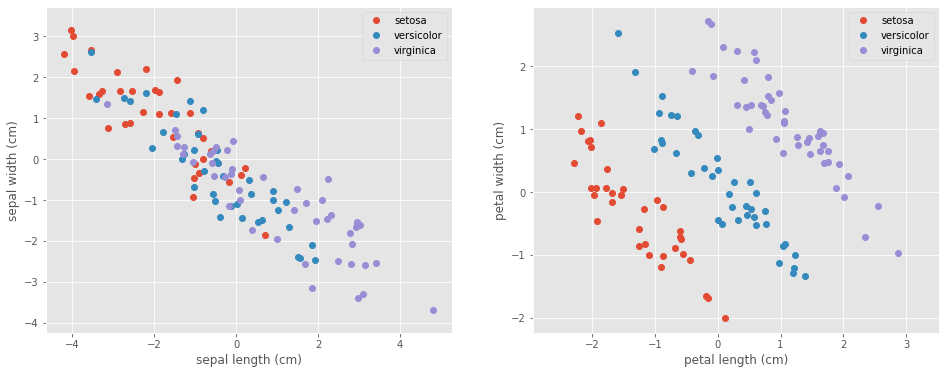

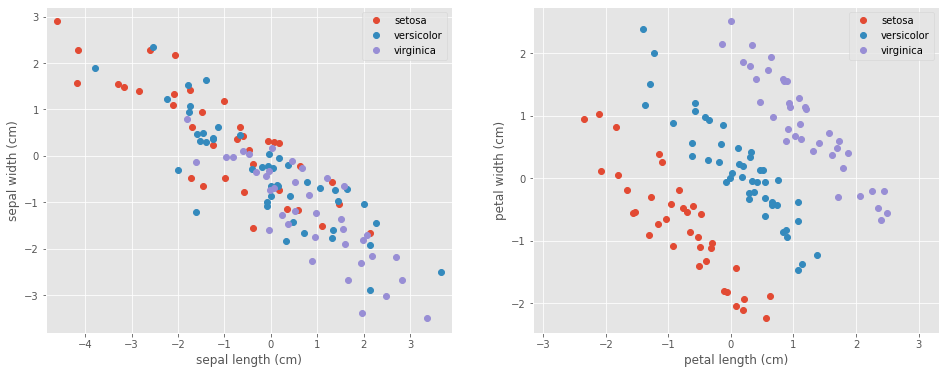

In [18]:
#Let's investigate what generated samples look like
for _ in range(2):

    #Generate a sample
    d = Data_sampler(zdim=zdim)
    wdata = d.wdata
    ydata = d.ydata
    
    wdata = torch.cat((wdata,real_data),dim=1) #the new wdata
    xdata = g(wdata) #synthetic data. i.e. (xdata,ydata)

    #Convert it to format for plotting
    xdata = xdata[0].detach().numpy()
    
    ydata = ydata.numpy()
    
    print(wdata)
    input()


    #Now need to replace X and y by xdata and ydata resp:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    for target, target_name in enumerate(names):
        X_plot = xdata[ydata == target]
        ax1.plot(X_plot[:, 0], X_plot[:, 1], 
                 linestyle='none', 
                 marker='o', 
                 label=target_name)
    ax1.set_xlabel(feature_names[0])
    ax1.set_ylabel(feature_names[1])
    ax1.axis('equal')
    ax1.legend();

    for target, target_name in enumerate(names):
        X_plot = xdata[ydata == target]
        ax2.plot(X_plot[:, 2], X_plot[:, 3], 
                 linestyle='none', 
                 marker='o', 
                 label=target_name)
    ax2.set_xlabel(feature_names[2])
    ax2.set_ylabel(feature_names[3])
    ax2.axis('equal')
    ax2.legend();
    

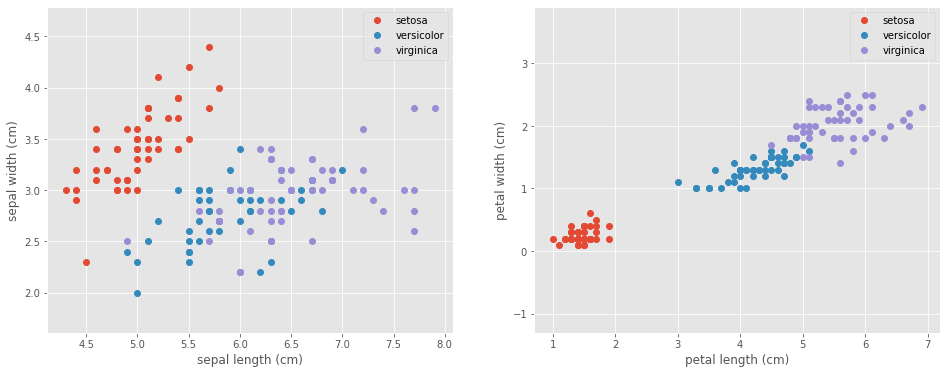

In [68]:
#Compare synthetic data above to the real samples below

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
for target, target_name in enumerate(names):
    X_plot = X[y == target]
    ax1.plot(X_plot[:, 0], X_plot[:, 1], 
             linestyle='none', 
             marker='o', 
             label=target_name)
ax1.set_xlabel(feature_names[0])
ax1.set_ylabel(feature_names[1])
ax1.axis('equal')
ax1.legend();

for target, target_name in enumerate(names):
    X_plot = X[y == target]
    ax2.plot(X_plot[:, 2], X_plot[:, 3], 
             linestyle='none', 
             marker='o', 
             label=target_name)
ax2.set_xlabel(feature_names[2])
ax2.set_ylabel(feature_names[3])
ax2.axis('equal')
ax2.legend();